In [ ]:
%pip install -U langgraph langchain-community langchain-anthropic tavily-python 

In [ ]:
%pip install python-dotenv

In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [ ]:
%pip install langchain-groq

In [ ]:
# StateGraph: Structure of chatbot as state machine
from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


In [ ]:
%pip install langchain-openai

In [ ]:
class State(TypedDict):
    # append message to the list
    messages: Annotated[list, add_messages] 
    

In [ ]:
graph_builder = StateGraph(State)

In [ ]:
from langchain_anthropic import ChatAnthropic

In [ ]:
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)
# llm = ChatOpenAI(model="gpt-3.5-turbo")

In [ ]:
def chatbot(state: State):
    #Every node will receive the current State as input and return a value that update that state.
    return {"messages" : [llm.invoke(state["messages"])]}

In [ ]:
graph_builder.add_node("chatbot", chatbot)

In [ ]:
graph_builder.set_entry_point("chatbot")

In [ ]:
graph_builder.set_finish_point("chatbot")

In [ ]:
#To run our graph we call compile() on the graph builder

In [ ]:
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [ ]:
while True:
    user_input = input("User:")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye")
        break
    for event in graph.stream({"messages" :("user", user_input)}):
        for value in event.values():
            print("Assistant: ", value["messages"][-1].content)

In [ ]:
%pip install -U tavily-python

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools=[tool]
tool.invoke("What is node in LangGraph?")

In [ ]:
llm_with_tools = llm.bind_tools(tools)


In [ ]:
def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [ ]:
graph_builder.add_node("chatbot", chatbot)

In [ ]:

from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    # append message to the list
    messages: Annotated[list, add_messages] 

tool = TavilySearchResults(max_results=3)
tools=[tool]

llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")


graph = graph_builder.compile()

In [ ]:
while True:
    user_input = input("User:")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye")
        break
    for event in graph.stream({"messages" :("user", user_input)}):
        for value in event.values():
            print("Assistant: ", value["messages"][-1].content)

In [ ]:
# BasicToolNode which checks the most recent message in the state and calls tools if the message contains tool_calls

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver

In [ ]:
memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
from typing import Annotated 
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

class State(TypedDict):
    # append message to the list
    messages: Annotated[list, add_messages] 

tool = TavilySearchResults(max_results=3)
tools=[tool]

llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")


memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["tools"],)

In [6]:
while True:
    user_input = input("User:")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye")
        break
    config = {"configurable": {"thread_id": "1"}}
    events = graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values")
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

================================ Human Message =================================

What is langgraph from langchain?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_tzst)
 Call ID: call_tzst
  Args:
    query: langgraph from langchain
Goodbye


In [8]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_tzst)
 Call ID: call_tzst
  Args:
    query: langgraph from langchain


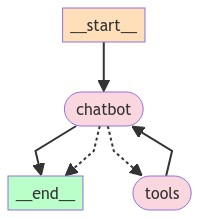

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass